In [3]:
%matplotlib inline
from __future__ import print_function, division
import sys, os
import json
import math
import itertools, collections
import datetime as dt

In [4]:
import fiona
from shapely.geometry import shape
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster")
#sns.set_context("talk", font_scale=1.4)

In [2]:
import geopandas as gp
import pandas as pd

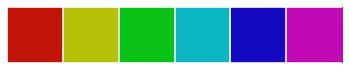

In [5]:
current_palette = sns.color_palette(sns.hls_palette(6, l=.4, s=.9))
sns.set_palette(current_palette)
sns.palplot(current_palette)
palette = itertools.cycle(sns.color_palette())

We use Alaska Albers shapefiles all around to be able to measure distances in metres. The WGS84 shapefiles from AICC and the Forest Service Active Fire Maps web portal were converted using GDAL: 

`ogr2ogr -f "ESRI Shapefile" outfile_AKAlbers.shp infile.shp -s_srs EPSG:4326 -t_SRS EPSG:3338` 

### Data loading - remotely sensed hotspots

Active fire hotspots from activefiremaps.fs.fed.us:

In [6]:
firehotspots = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/activefiremaps.fs.fed.us_data_fireptdata/"
mod14dir = "modis_fire_2015_344_ak_shapefile"
mod14shp = "modis_fire_2015_344_ak_AKAlbers.shp"
viirsMdir = "viirs-af_fire_2015_344_ak_shapefile"
viirsMshp = "viirs-af_fire_2015_344_ak_AKAlbers.shp"
viirsIdir = "viirs_iband_fire_2015_344_ak_shapefile"
viirsIshp = "viirs_iband_fire_2015_344_ak_AKAlbers.shp"

In [7]:
mod14DF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, mod14dir, mod14shp))
viirsIDF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, viirsIdir, viirsIshp))

In [8]:
mod14DF.head()

,AREA,CONF,DATE,FIRE_,FIRE_ID,FRP,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SPIX,SRC,TEMP,TPIX,geometry
0,0,51,2015-08-25,1,556152,18.5,548,237,70.320,-148.538,0,T,1.5,uaf,302.8,1.2,POINT (209006.9285980303 2268502.338402809)
1,0,100,2015-10-07,2,578084,52.0,710,280,70.292,-148.422,0,T,1.1,gsfc,328.2,1.0,POINT (213692.6530392757 2265815.761972296)
2,0,100,2015-10-07,3,578083,62.5,710,280,70.289,-148.449,0,T,1.1,gsfc,334.2,1.0,POINT (212688.1326305367 2265401.676873978)
3,0,51,2015-07-04,4,453637,5.7,2252,185,68.057,-153.823,0,T,1.4,uaf,306.8,1.2,POINT (7444.753524688874 2010738.905582397)
4,0,61,2015-07-26,5,480744,10.6,2354,207,67.933,-163.619,0,T,2.0,uaf,305.5,1.4,POINT (-405150.1668644578 2026400.42526813)


### Output settings

In [9]:
gisoutdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/'
hotspotsviirsprefix = 'VIIRS-I_'

### Generate by-day files from VIIRS and MODIS 

Structure is "LON LAT AREA".

In [14]:
dates = [
    ('2015', '06', '18'),
    ('2015', '06', '19'),
    ('2015', '06', '20'),
    ('2015', '06', '21'),
    ('2015', '06', '22'),
    ('2015', '06', '23'),
    ('2015', '06', '24'),
    ('2015', '06', '25'),
    ('2015', '06', '26'),
    ('2015', '06', '27'),
    ('2015', '06', '28'),
    ('2015', '06', '29'),
    ('2015', '06', '30'),
]

In [20]:
for dat in dates:
    date1 = '-'.join(dat)
    date2 = ''.join(dat)
    fn = hotspotsviirsprefix + date2 + '.dat'
    outfp = os.path.join(gisoutdir, fn)
    dummy = viirsIDF[viirsIDF['DATE'] == date1][['LONG', 'LAT']]
    dummy['AREA'] = 0.15
    dummy.to_csv(path_or_buf=outfp, sep=' ', header=False, index=False)

### Investigate times of hotspots - throughout the fire season and time-of-day

In [10]:
def get_time_AKDT(row):
    datest = dt.datetime.strptime(row['DATE'] + str(row['GMT']).zfill(4), "%Y-%m-%d%H%M")
    datest -= dt.timedelta(hours=8)
    return datest.strftime('%H%M')

viirsIAKDTtimes = viirsIDF.apply(lambda row: int(get_time_AKDT(row)), axis=1)
mod14AKDTtimes = mod14DF.apply(lambda row: int(get_time_AKDT(row)), axis=1)

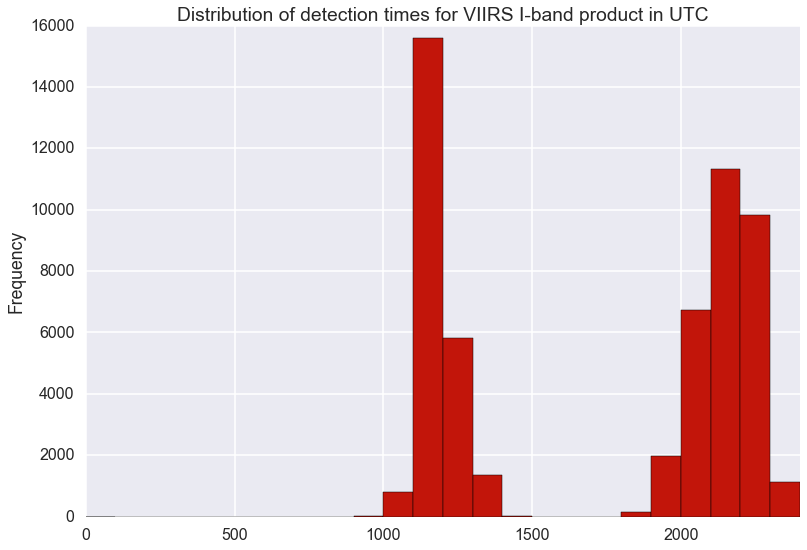

In [10]:
viirsIDF['GMT'].plot(kind='hist', bins=24, range=(0, 2400), xlim=(0, 2400))
ax1 = plt.gca()
ax1.set_title("Distribution of detection times for VIIRS I-band product in UTC")

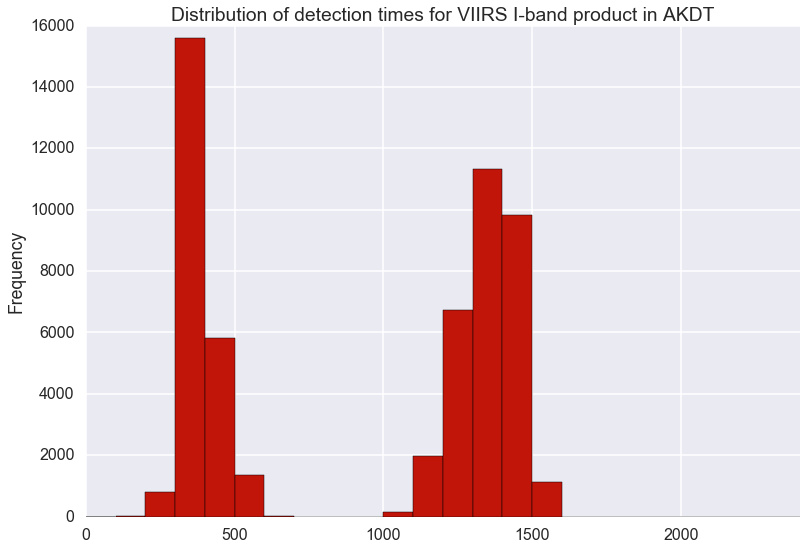

In [12]:
viirsIAKDTtimes.plot(kind='hist', bins=24, range=(0, 2400), xlim=(0, 2400))
ax1 = plt.gca()
ax1.set_title("Distribution of detection times for VIIRS I-band product in AKDT")

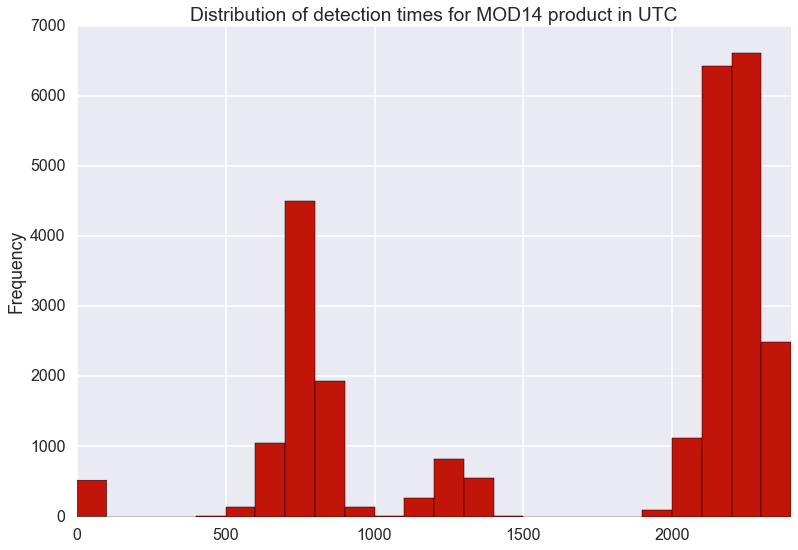

In [16]:
mod14DF['GMT'].plot(kind='hist', bins=24, range=(0, 2400), xlim=(0, 2400))
ax1 = plt.gca()
ax1.set_title("Distribution of detection times for MOD14 product in UTC")

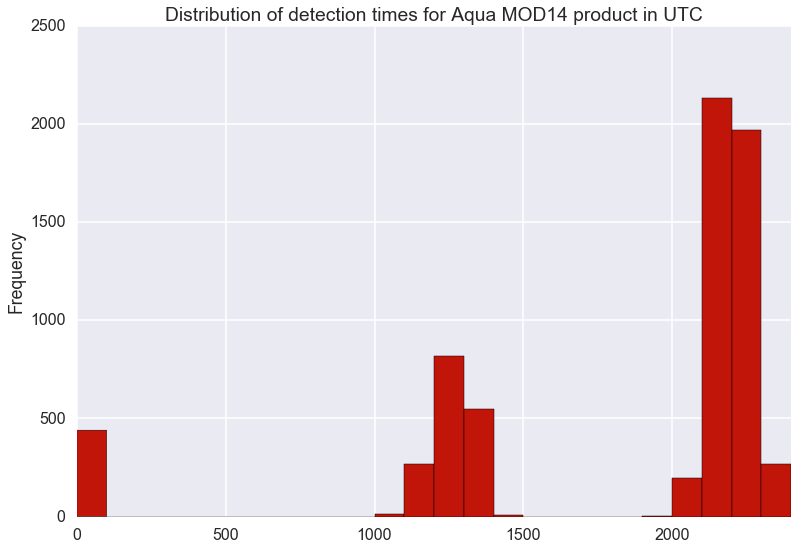

In [25]:
mod14DF.loc[mod14DF['SAT_SRC'] == 'A', 'GMT'].plot(kind='hist', bins=24, range=(0, 2400), xlim=(0, 2400))
ax1 = plt.gca()
ax1.set_title("Distribution of detection times for Aqua MOD14 product in UTC")

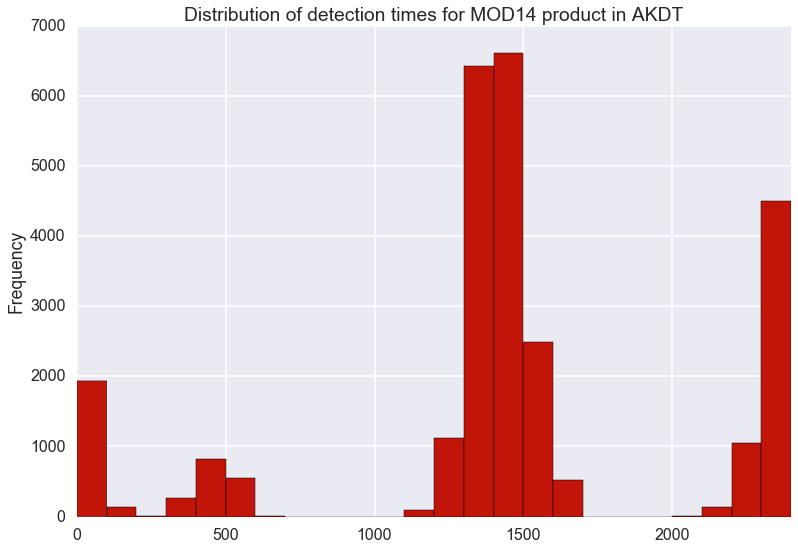

In [20]:
mod14AKDTtimes.plot(kind='hist', bins=24, range=(0, 2400), xlim=(0, 2400))
ax1 = plt.gca()
ax1.set_title("Distribution of detection times for MOD14 product in AKDT")

In [11]:
mod14DF['DateTime'] = pd.to_datetime(mod14DF['DATE'] + ' ' + mod14DF['GMT'].apply(
        lambda a: str(a).zfill(4)), format='%Y-%m-%d %H%M')
mod14DF = mod14DF.set_index('DateTime')
mod14DF['2015-08-09':'2015-08-27']

,AREA,CONF,DATE,FIRE_,FIRE_ID,FRP,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SPIX,SRC,TEMP,TPIX,geometry
DateTime,,,,,,,,,,,,,,,,,
2015-08-25 05:48:00,0,51,2015-08-25,1,556152,18.5,548,237,70.320,-148.538,0,T,1.5,uaf,302.8,1.2,POINT (209006.9285980303 2268502.338402809)
2015-08-15 21:51:00,0,37,2015-08-15,23012,513048,13.7,2151,227,62.572,-141.520,0,T,2.0,uaf,305.3,1.4,POINT (635942.3102424212 1459858.461908715)
2015-08-15 20:13:00,0,8,2015-08-15,26668,513023,7.7,2013,227,57.415,-132.376,0,T,1.0,uaf,300.4,1.0,POINT (1273349.190643046 1032546.347582946)


In [12]:
viirsIDF['DateTime'] = pd.to_datetime(viirsIDF['DATE'] + ' ' + viirsIDF['GMT'].apply(
        lambda a: str(a).zfill(4)), format='%Y-%m-%d %H%M')
viirsIDF = viirsIDF.set_index('DateTime')
viirsIDF['2015-08-9':'2015-08-27'].to_crs(epsg=4326).head()

,AREA,BT4TEMP,BT5TEMP,CONF,DATE,FIRE_,FIRE_ID,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SRC,geometry
DateTime,,,,,,,,,,,,,,,
2015-08-25 12:42:00,0,321.5,255.4,Nominal,2015-08-25,2,662961,1242,237,70.326,-148.527,0,S-NPP,rsac,POINT (-148.52699 70.32571000059731)
2015-08-21 12:17:00,0,300.2,266.5,Nominal,2015-08-21,3,626561,1217,233,70.325,-148.527,0,S-NPP,rsac,POINT (-148.52667 70.32507000059735)
2015-08-25 12:42:00,0,297.3,259.0,Nominal,2015-08-25,4,660305,1242,237,70.324,-148.517,0,S-NPP,rsac,POINT (-148.51671 70.3243400005973)
2015-08-27 13:44:00,0,329.0,262.9,Nominal,2015-08-27,13,677762,1344,239,70.307,-148.859,0,S-NPP,rsac,POINT (-148.85899 70.30743000059773)
2015-08-25 12:42:00,0,298.4,265.4,Nominal,2015-08-25,16,661871,1242,237,70.291,-148.437,0,S-NPP,rsac,POINT (-148.43681 70.2913900005981)


In [13]:
viirsIDF[(viirsIDF['LAT'] > 70.15) & (viirsIDF['LONG'] < -148) & (viirsIDF['LONG'] > -149.25)].head()

,AREA,BT4TEMP,BT5TEMP,CONF,DATE,FIRE_,FIRE_ID,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SRC,geometry
DateTime,,,,,,,,,,,,,,,
2015-09-03 11:32:00,0,295.6,273.4,Nominal,2015-09-03,1,705023,1132,246,70.328,-148.531,0,S-NPP,rsac,POINT (209193.4961185405 2269427.470214345)
2015-08-25 12:42:00,0,321.5,255.4,Nominal,2015-08-25,2,662961,1242,237,70.326,-148.527,0,S-NPP,rsac,POINT (209375.8106070208 2269160.153930458)
2015-08-21 12:17:00,0,300.2,266.5,Nominal,2015-08-21,3,626561,1217,233,70.325,-148.527,0,S-NPP,rsac,POINT (209393.7939770371 2269091.320873827)
2015-08-25 12:42:00,0,297.3,259.0,Nominal,2015-08-25,4,660305,1242,237,70.324,-148.517,0,S-NPP,rsac,POINT (209780.5617507724 2269043.090421114)
2015-07-31 20:29:00,0,328.3,290.1,Nominal,2015-07-31,5,527799,2029,212,70.324,-148.522,0,S-NPP,rsac,POINT (209566.6907615381 2268961.67384518)


In [14]:
mod14DF[(mod14DF['LAT'] > 70.15) & (mod14DF['LONG'] < -148) & (mod14DF['LONG'] > -149.25)]

,AREA,CONF,DATE,FIRE_,FIRE_ID,FRP,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SPIX,SRC,TEMP,TPIX,geometry
DateTime,,,,,,,,,,,,,,,,,
2015-08-25 05:48:00,0,51,2015-08-25,1,556152,18.5,548,237,70.320,-148.538,0,T,1.5,uaf,302.8,1.2,POINT (209006.9285980303 2268502.338402809)
2015-10-07 07:10:00,0,100,2015-10-07,2,578084,52.0,710,280,70.292,-148.422,0,T,1.1,gsfc,328.2,1.0,POINT (213692.6530392757 2265815.761972296)
2015-10-07 07:10:00,0,100,2015-10-07,3,578083,62.5,710,280,70.289,-148.449,0,T,1.1,gsfc,334.2,1.0,POINT (212688.1326305367 2265401.676873978)


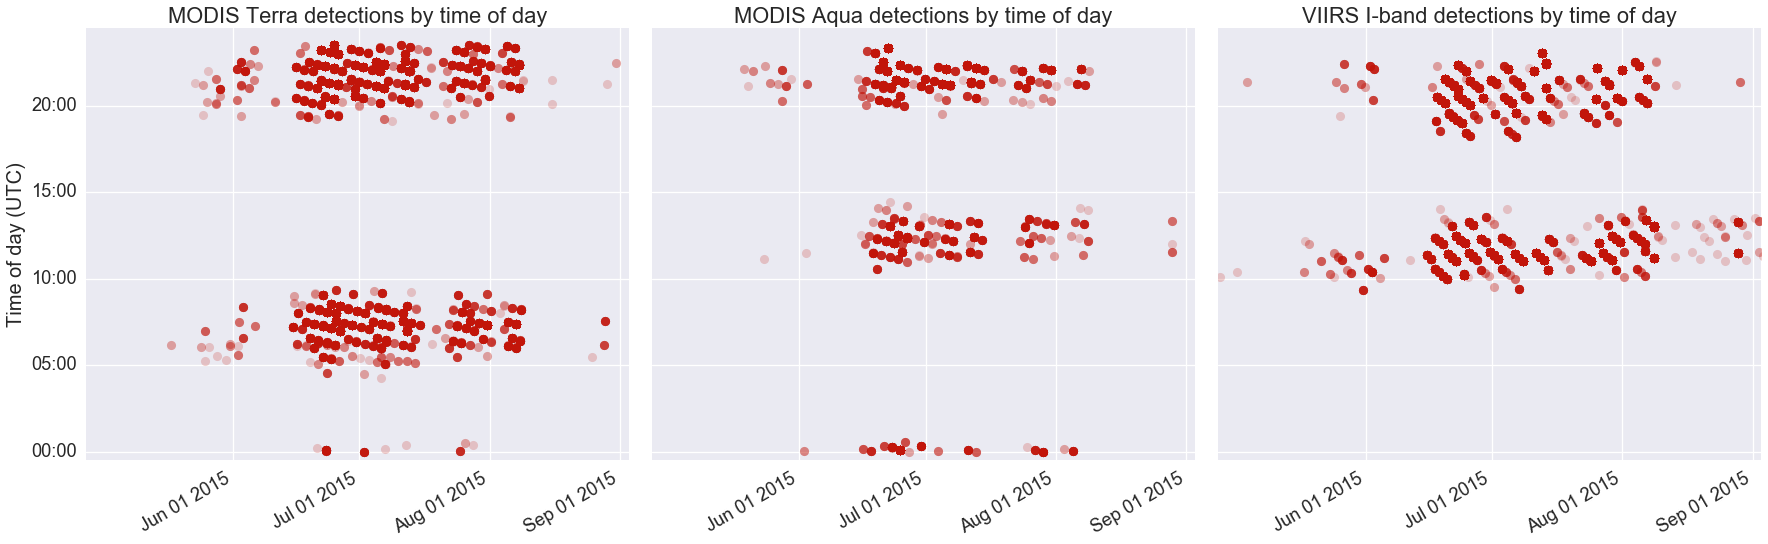

In [40]:
sns.set_context("talk", font_scale=1.4)
SAVEFIG = True

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(25, 8), sharex=True, sharey=True)
pd.tools.plotting.plot_frame(
    mod14DF.loc[mod14DF['SAT_SRC'] == 'T', 'GMT']['2015-04-27':'2015-09-03'], 
    marker='o', alpha=0.2, linewidth=0,
    xlim=('2015-04-27', '2015-09-03'), ylim=(-50, 2450),
    ax=ax0
)
pd.tools.plotting.plot_frame(
    mod14DF.loc[mod14DF['SAT_SRC'] == 'A', 'GMT']['2015-04-27':'2015-09-03'], 
    marker='o', alpha=0.2, linewidth=0,
    xlim=('2015-04-27', '2015-09-03'), ylim=(-50, 2450),
    ax=ax1
)
pd.tools.plotting.plot_frame(
    viirsIDF['GMT']['2015-04-27':'2015-09-03'], 
    marker='o', alpha=0.2, linewidth=0,
    xlim=('2015-04-27', '2015-09-03'), ylim=(-50, 2450),
    ax=ax2
)
ax0.set_yticklabels(['xxx', '00:00', '05:00', '10:00', '15:00', '20:00'])
ax0.set_ylabel('Time of day (UTC)')
ax0.set_xticks(pd.date_range('2015-06', '2015-09', freq='MS'))
ax0.set_xlabel('')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax0.set_title('MODIS Terra detections by time of day')
ax1.set_title('MODIS Aqua detections by time of day')
ax2.set_title('VIIRS I-band detections by time of day')
ax0.legend().set_visible(False)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
plt.tight_layout()

if SAVEFIG:
    outfn = 'mod_and_viirs_timescatter.png'
    plt.savefig(os.path.join(gisoutdir, outfn), dpi=300, bbox_inches='tight')     

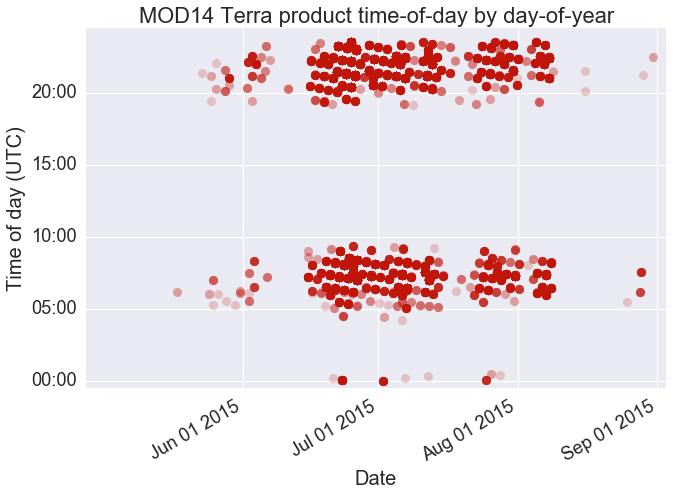

In [33]:
SAVEFIG = False

pd.tools.plotting.plot_frame(
    mod14DF.loc[mod14DF['SAT_SRC'] == 'T', 'GMT']['2015-04-27':'2015-09-03'], marker='o', alpha=0.2, linewidth=0,
    xlim=('2015-04-27', '2015-09-03'), ylim=(-50, 2450),
)
ax = plt.gca()
ax.set_yticklabels(['xxx', '00:00', '05:00', '10:00', '15:00', '20:00'])
ax.set_ylabel('Time of day (UTC)')
ax.set_xticks(pd.date_range('2015-06', '2015-09', freq='MS'))
ax.set_xlabel('Date')
ax.legend().set_visible(False)
ax.set_title("MOD14 Terra product time-of-day by day-of-year")
if SAVEFIG:
    outfn = 'mod14_terra_timescatter.png'
    plt.savefig(os.path.join(gisoutdir, outfn), dpi=200, bbox_inches='tight')

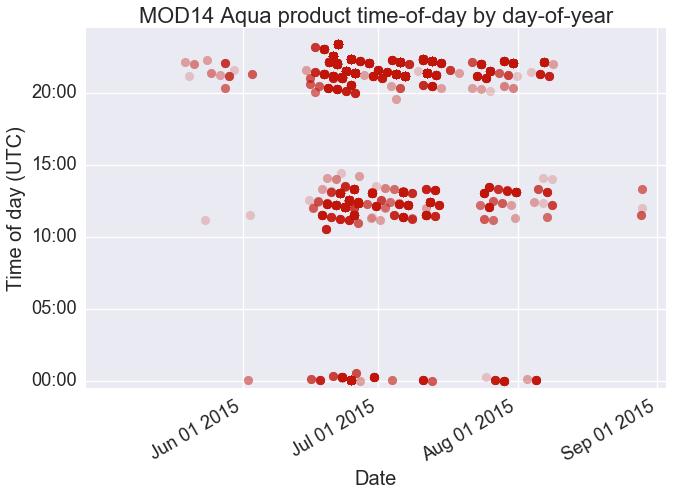

In [34]:
SAVEFIG = False

pd.tools.plotting.plot_frame(
    mod14DF.loc[mod14DF['SAT_SRC'] == 'A', 'GMT']['2015-04-27':'2015-09-03'], marker='o', alpha=0.2, linewidth=0,
    xlim=('2015-04-27', '2015-09-03'), ylim=(-50, 2450),
)
ax = plt.gca()
ax.set_yticklabels(['xxx', '00:00', '05:00', '10:00', '15:00', '20:00'])
ax.set_ylabel('Time of day (UTC)')
ax.set_xticks(pd.date_range('2015-06', '2015-09', freq='MS'))
ax.set_xlabel('Date')
ax.legend().set_visible(False)
ax.set_title("MOD14 Aqua product time-of-day by day-of-year")
if SAVEFIG:
    outfn = 'mod14_aqua_timescatter.png'
    plt.savefig(os.path.join(gisoutdir, outfn), dpi=200, bbox_inches='tight')

In [45]:
outfn = 'viirsI-Aug2015_lowphase.shp'
viirsIDF['2015-08-9':'2015-08-27'].to_crs(epsg=4326).to_file(
    os.path.join(gisoutdir, outfn), driver="ESRI Shapefile")

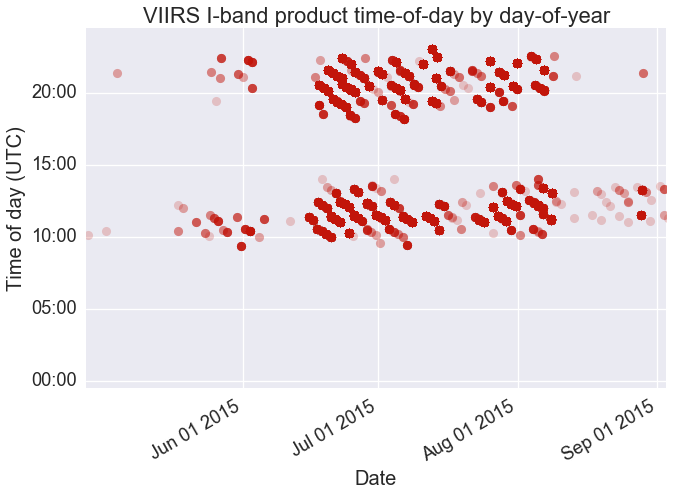

In [35]:
SAVEFIG = False

pd.tools.plotting.plot_frame(
    viirsIDF['GMT']['2015-04-27':'2015-09-03'], marker='o', alpha=0.2, linewidth=0,
    xlim=('2015-04-27', '2015-09-03'), ylim=(-50, 2450),
)
ax = plt.gca()
ax.set_yticklabels(['xxx', '00:00', '05:00', '10:00', '15:00', '20:00'])
ax.set_ylabel('Time of day (UTC)')
ax.set_xticks(pd.date_range('2015-06', '2015-09', freq='MS'))
ax.set_xlabel('Date')
ax.legend().set_visible(False)
ax.set_title("VIIRS I-band product time-of-day by day-of-year")
if SAVEFIG:
    outfn = 'viirs-i_timescatter.png'
    plt.savefig(os.path.join(gisoutdir, outfn), dpi=200, bbox_inches='tight')

In [55]:
a = viirsIDF['2015-06-15':'2015-06-24']

a[a['GMT'] > 1600]

,AREA,BT4TEMP,BT5TEMP,CONF,DATE,FIRE_,FIRE_ID,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SRC,geometry
DateTime,,,,,,,,,,,,,,,
2015-06-24 22:02:00,0,347.0,304.3,Nominal,2015-06-24,83,273906,2202,175,67.469,-145.286,0,S-NPP,rsac,POINT (373978.67606655 1970185.146186735)
2015-06-24 20:22:00,0,337.8,293.6,Nominal,2015-06-24,88,272575,2022,175,67.466,-145.297,0,S-NPP,rsac,POINT (373575.244913956 1969784.219100558)
2015-06-24 22:02:00,0,336.5,301.8,Nominal,2015-06-24,90,270408,2202,175,67.466,-145.283,0,S-NPP,rsac,POINT (374163.7828056918 1969851.792184871)
2015-06-24 22:02:00,0,334.8,304.8,Low,2015-06-24,93,271610,2202,175,67.465,-145.292,0,S-NPP,rsac,POINT (373787.5579333294 1969665.743806941)
2015-06-24 22:02:00,0,328.9,300.8,Low,2015-06-24,106,267891,2202,175,67.459,-145.277,0,S-NPP,rsac,POINT (374519.6022575865 1969176.483715545)
2015-06-24 22:02:00,0,350.7,299.1,Nominal,2015-06-24,138,269153,2202,175,67.435,-145.103,0,S-NPP,rsac,POINT (382310.3325448234 1967485.07757223)
2015-06-24 22:02:00,0,333.4,299.8,Nominal,2015-06-24,141,268855,2202,175,67.433,-145.091,0,S-NPP,rsac,POINT (382858.1130369065 1967328.522086282)
2015-06-24 22:02:00,0,367.0,350.6,Nominal,2015-06-24,144,268590,2202,175,67.432,-145.100,0,S-NPP,rsac,POINT (382485.3275925604 1967145.117692602)
2015-06-24 20:22:00,0,343.2,294.7,Nominal,2015-06-24,145,268853,2022,175,67.431,-145.109,0,S-NPP,rsac,POINT (382088.9672483645 1966994.387781206)


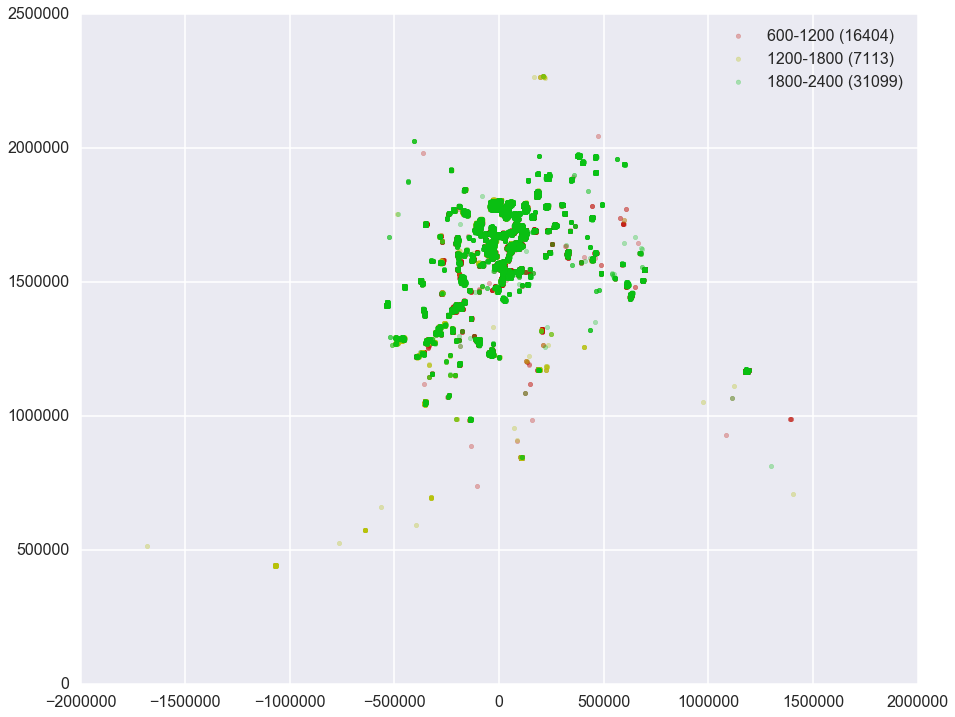

In [18]:
fig1, ax1 = plt.subplots(figsize=(15, 12))
starttimes = [600, 1200, 1800]
endtimes = [1200, 1800, 2400]
for st, ed in zip(starttimes, endtimes):
    xs = viirsIDF.loc[
        (viirsIDF['GMT'] < ed) & (viirsIDF['GMT'] > st), 'geometry'].apply(lambda item: item.x).values
    ys = viirsIDF.loc[
        (viirsIDF['GMT'] < ed) & (viirsIDF['GMT'] > st), 'geometry'].apply(lambda item: item.y).values
    plt.scatter(xs, ys, edgecolor=None, color=palette.next(), alpha=0.3, label="{}-{} ({})".format(st, ed, len(xs)))
plt.legend()

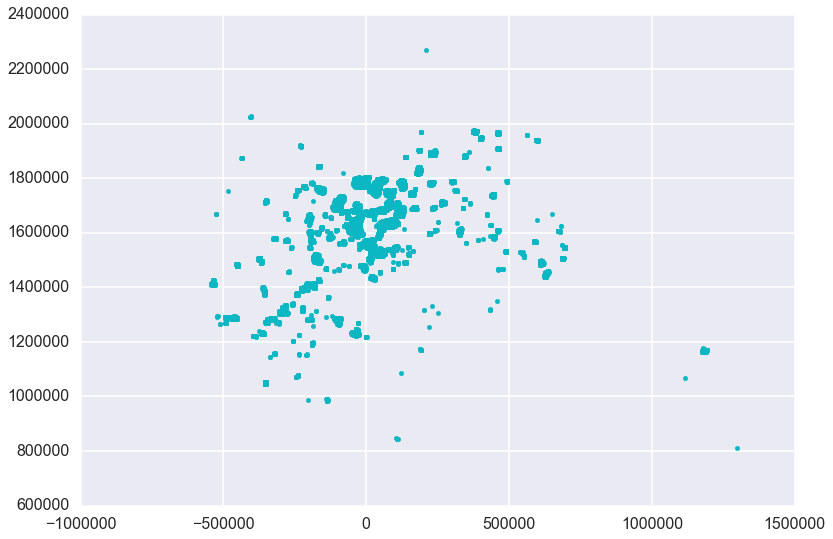

In [19]:
plt.scatter(xs, ys, edgecolor=None, color=palette.next())

In [20]:
viirsIDF['x'] = viirsIDF['geometry'].apply(lambda item: item.x)
viirsIDF['y'] = viirsIDF['geometry'].apply(lambda item: item.y)
mod14DF['x'] = mod14DF['geometry'].apply(lambda item: item.x)
mod14DF['y'] = mod14DF['geometry'].apply(lambda item: item.y)

In [21]:
def get_timeslice(gmttime, hours=6):
    """gmttime is in 'miltary time', between 0 and 2359"""
    hoursdiv = hours * 100
    slc = int(gmttime) // hoursdiv
    return "{}-{}".format(slc*hoursdiv, min((slc+1)*hoursdiv, 2400))

get_timeslice(500, hours=5)
    

'500-1000'

In [24]:
viirsIDF['utcinterval'] = viirsIDF['GMT'].apply(get_timeslice)
mod14DF['utcinterval'] = mod14DF['GMT'].apply(get_timeslice)

In [35]:
cols = ['0-600', '600-1200', '1200-1800', '1800-2400']

In [28]:
statedf = gp.GeoDataFrame.from_file("/Volumes/SCIENCE_mobile_Mac/GENERAL_GIS/census_gov/cb_2014_us_state_20m/cb_2014_us_state_20m.shp")
multipolyAK = statedf[statedf['NAME'] == 'Alaska']['geometry'].to_crs(viirsIDF.crs).values[0]
patches = [PolygonPatch(poly, facecolor=None, alpha=.1) for poly in multipolyAK]    

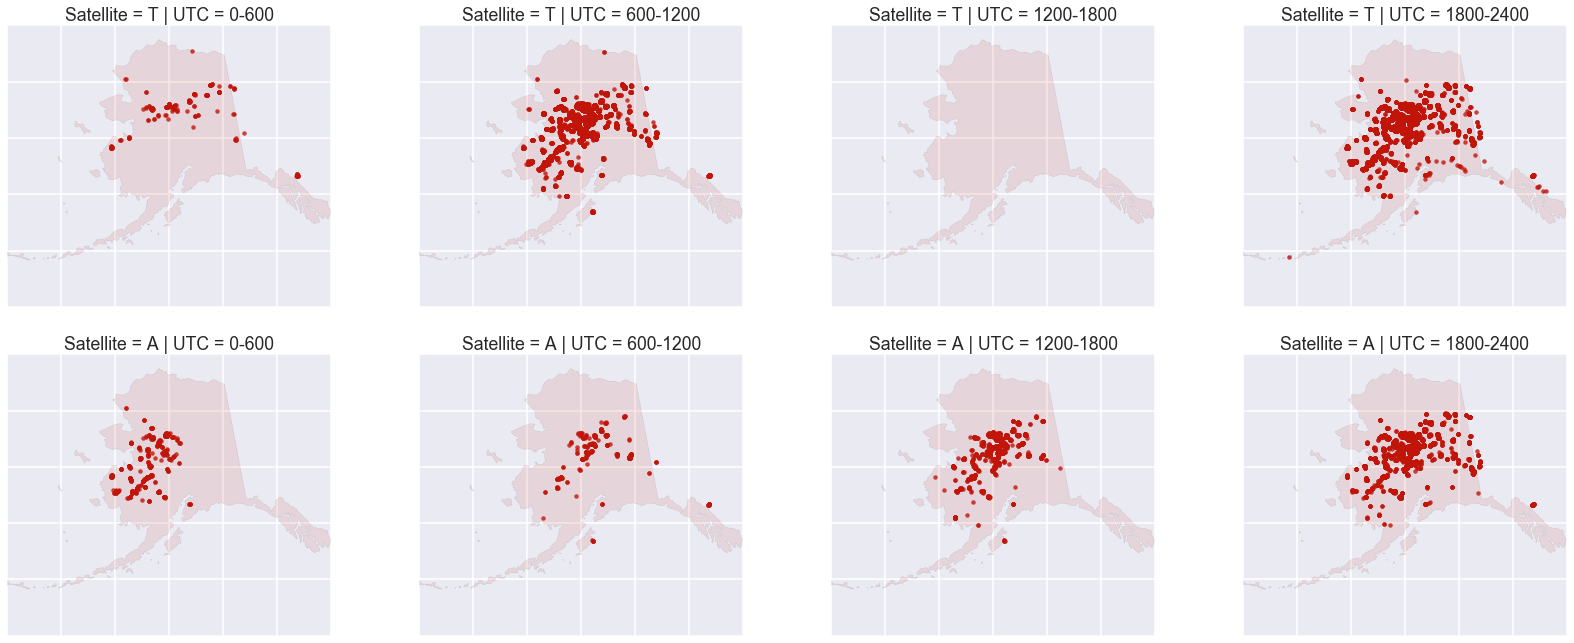

In [39]:
SAVEFIG = True
lm = sns.lmplot(
    'x', 'y', col='utcinterval', row='SAT_SRC', 
    col_order=cols, data=mod14DF, fit_reg=False, aspect=1.2, legend=False)
lm = (lm.set_titles("Satellite = {row_name} | UTC = {col_name}"))
lm.set_xticklabels([])
lm.set_yticklabels([])
lm.set_xlabels('')
lm.set_ylabels('')
axes = lm.axes
for ax in axes.flatten():
    ax.add_collection(PatchCollection(patches, match_original=True))
if SAVEFIG:
    plt.savefig(os.path.join(gisoutdir, "MOD14maps.png"), dpi=400, bbox_inches='tight')

In [41]:
cols = ['600-1200', '1200-1800', '1800-2400']

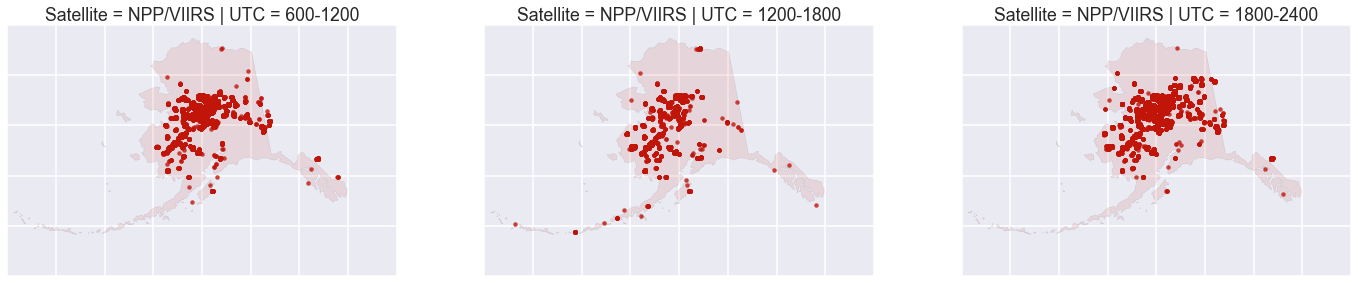

In [42]:
SAVEFIG = True
lm = sns.lmplot('x', 'y', col='utcinterval', data=viirsIDF, col_order=cols, fit_reg=False, aspect=1.4, legend=False)
lm = (lm.set_titles("Satellite = NPP/VIIRS | UTC = {col_name}"))
lm.set_xticklabels([])
lm.set_yticklabels([])
lm.set_xlabels('')
lm.set_ylabels('')
axes = lm.axes
for ax in axes.flatten():
    ax.add_collection(PatchCollection(patches, match_original=True))
plt.savefig(os.path.join(gisoutdir, "VIIRSmaps.png"), dpi=400, bbox_inches='tight')